# Brin Tumor Segmentation Using UNET

**Objective**

To segment the portion of images where tumor is present using Deep Learning UNET architecture.


**What is UNET Architecture?**

The UNET was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. The architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

<img src="utils/unet_architecture.png">



## 1. Required Imports 💼

These are the libraries and their functions which are required for the execution of the project and the commonly used libararies are **os, pahtllib** (both are mainly used for fetching the data from the local files), **matplotlib** (for visualizing purposes), **numpy, random, tensorflow, sklearn** (related to the creation of the model, processing and analysing the data).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from os.path import isfile, join
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import metrics

## 2. Data exploration and visualization

**About the datatset(LGG Segmentation Dataset)**

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks. The images were obtained from The Cancer Imaging Archive (TCIA). They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556

In [23]:
# Define path and required variables
DIR = r"D:\MachineLearningProjects\project7sem\DIC_FINAL_PROJECT\Brain_Tumor_Segmentation\dataset\lgg-mri-segmentation\kaggle_3m"
INPUT_CHANNELS = 3
TARGET_CHANNELS = 1
SIZE = 256
BATCH_SIZE = 32

In [24]:
# Collection the paths of the images and masks which are with and without tumors
mri_images_with_tumer = []
mri_images_without_tumer = []
mask_images_with_tumer = []
mask_images_without_tumer = []

# Getting the list of directories
patients = os.listdir(DIR)
for patient in tqdm(patients):
    if isfile(join(DIR, patient)) == False:
        images = os.listdir(join(DIR, patient))
        mask_images = list(filter(lambda x: x.find('mask') != -1, images))
        mri_images = list(filter(lambda x: x.find('mask') == -1, images))
        
        for mask_image in mask_images:
            # Loading the image from the source
            mask = np.asarray(load_img(
                join(DIR, patient, mask_image), 
                target_size=(SIZE, SIZE), 
                color_mode="grayscale"))
            # If mask contains a tumor it will have max value 1, else 0
            if np.amax(mask) != 0:
                mri_images_with_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_with_tumer.append(join(patient, mask_image))
            else:
                mri_images_without_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_without_tumer.append(join(patient, mask_image))

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:08<00:00, 12.24it/s]


Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556


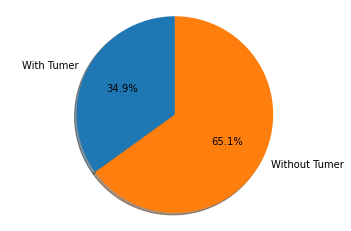

In [25]:
# Shuffling the data and plotting the pie plots
random.Random(1337).shuffle(mri_images_with_tumer)
random.Random(1337).shuffle(mask_images_with_tumer)
random.Random(1337).shuffle(mri_images_without_tumer)
random.Random(1337).shuffle(mask_images_without_tumer)


print("Total MRI images: ", len(mri_images_with_tumer) + len(mri_images_without_tumer))
print("Total mask images: ", len(mask_images_with_tumer) + len(mask_images_without_tumer))
print("Total images with tumer: ", len(mri_images_with_tumer))
print("Total images without tumer: ", len(mri_images_without_tumer))

labels = ['With Tumer', 'Without Tumer']
count = [len(mri_images_with_tumer), len(mri_images_without_tumer)]

fig, ax = plt.subplots()
ax.pie(count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [26]:
# Turning the list into numpy arrays
mri_images_with_tumer = np.array(mri_images_with_tumer)
mri_images_without_tumer = np.array(mri_images_without_tumer)
mask_images_with_tumer = np.array(mask_images_with_tumer)
mask_images_without_tumer = np.array(mask_images_without_tumer)

In [27]:
# Dividing the data into train, test and validation split
with_tumer_val_images = 300
without_tumer_val_images = 600

with_tumer_test_images = 10
without_tumer_test_images = 5

train_images = np.concatenate(
    (mri_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mri_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mri_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_test_images:], 
     mri_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

train_targets = np.concatenate(
    (mask_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mask_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mask_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_test_images:], 
     mask_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)


print("train_images: ", train_images.shape)
print("train_targets: ", train_targets.shape)
print("val_images: ", val_images.shape)
print("val_targets: ", val_targets.shape)
print("test_images: ", test_images.shape)
print("test_targets: ", test_targets.shape)

train_images:  (3014,)
train_targets:  (3014,)
val_images:  (900,)
val_targets:  (900,)
test_images:  (15,)
test_targets:  (15,)


In [28]:
# Shuffling the data to maintain randomness in the order of images
random.Random(37).shuffle(train_images)
random.Random(37).shuffle(train_targets)
random.Random(37).shuffle(val_images)
random.Random(37).shuffle(val_targets)

In [29]:
# Saving the test, train & validation splits into pandas dataframe
train_df = pd.DataFrame(data={'mris': train_images, 'masks': train_targets})
val_df = pd.DataFrame(data={'mris': val_images, 'masks': val_targets})
test_df = pd.DataFrame(data={'mris': test_images, 'masks': test_targets})

**Visualizing the training images**

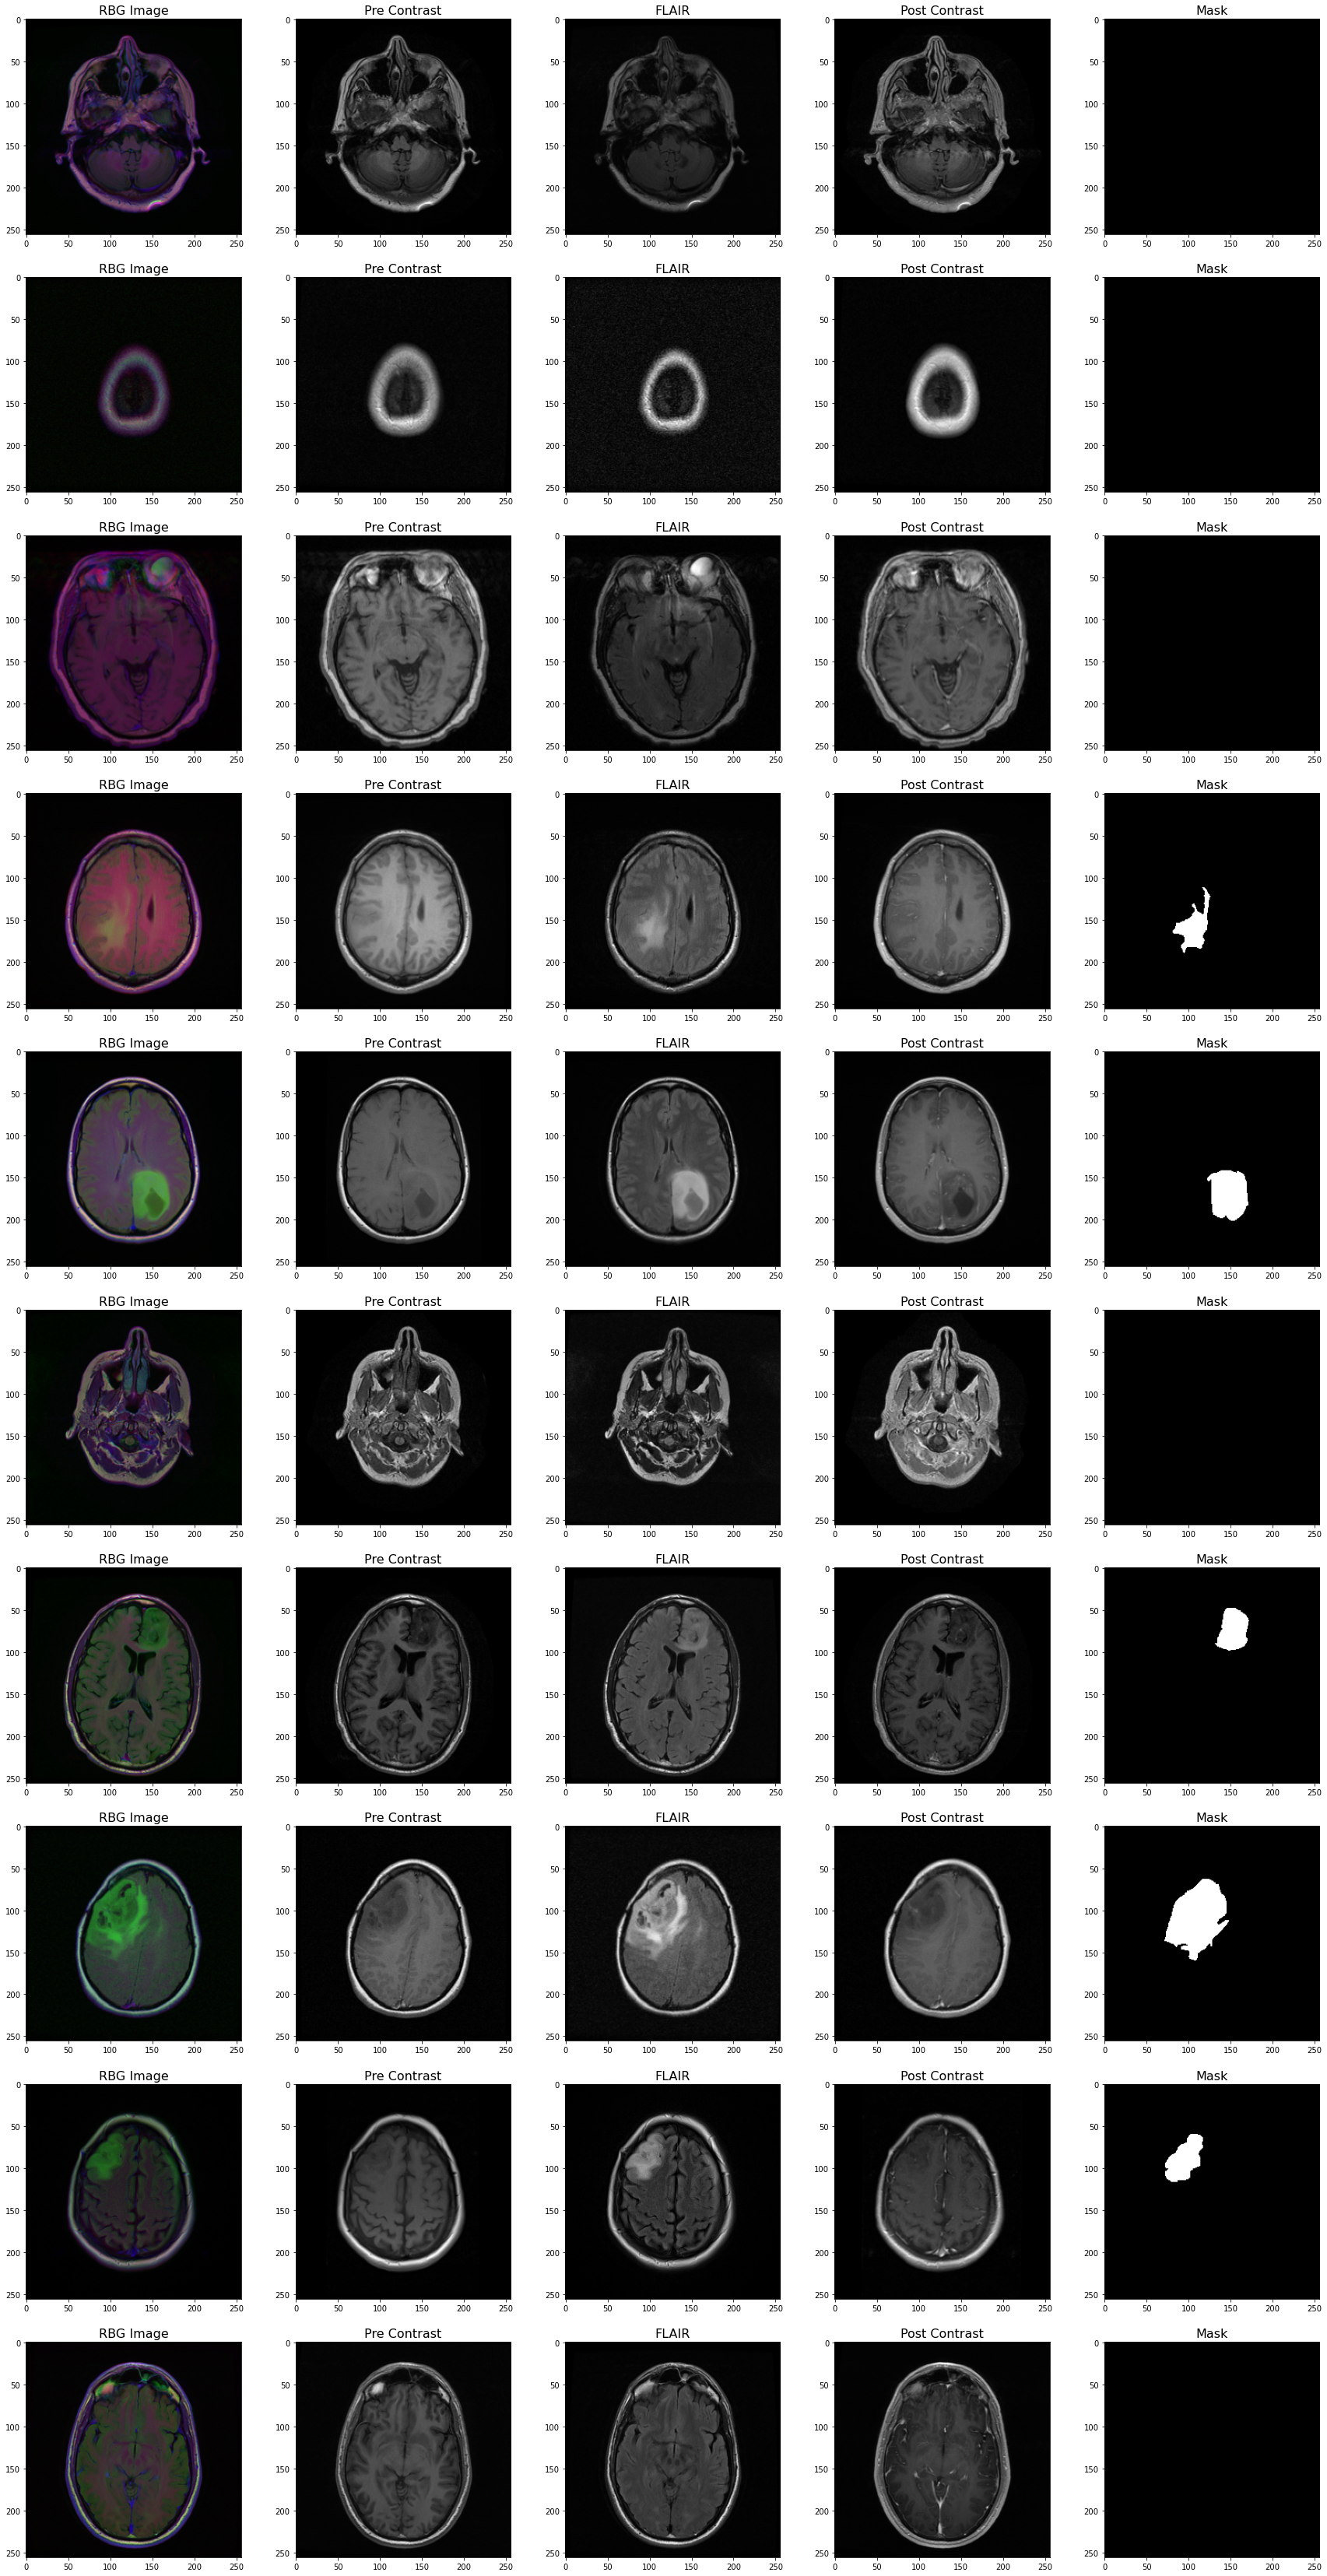

In [30]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 1000, 3)
    
    mri = np.asarray(load_img(
         join(DIR, train_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, train_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

**Visualizing the validation images**

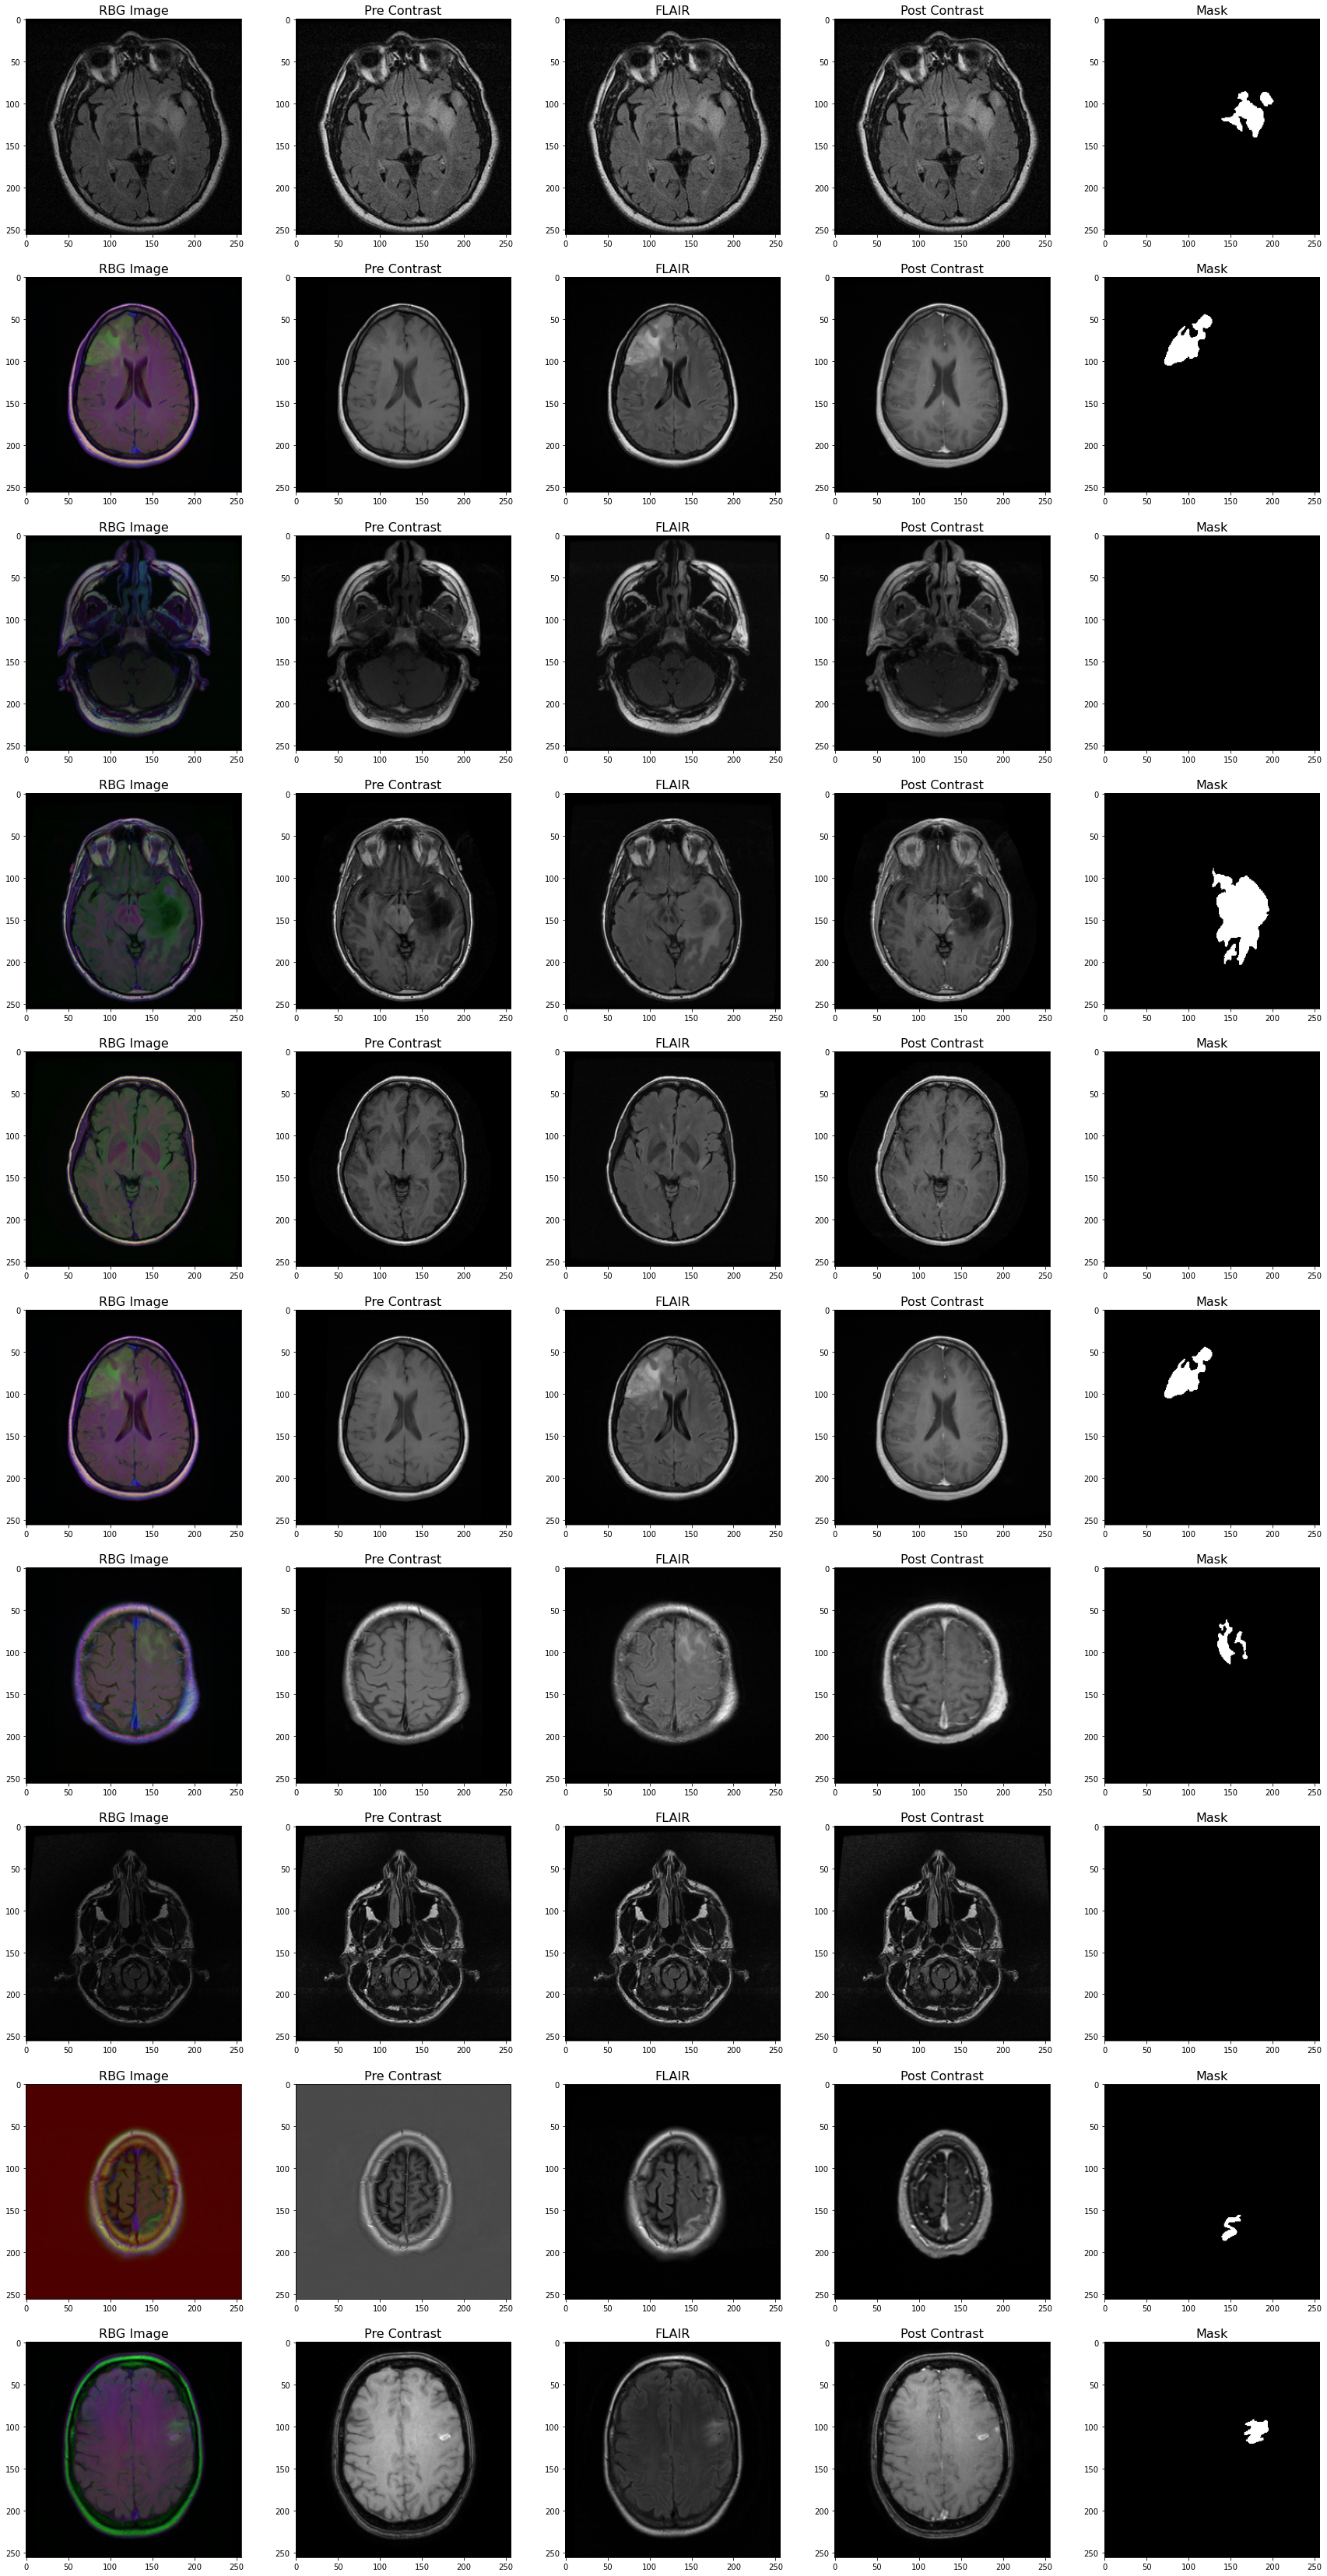

In [31]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 200, 3)
    
    mri = np.asarray(load_img(
         join(DIR, val_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, val_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

## 3. Data Loading using Custom Data Generator

* `Data generators` are used to load data directly into the model while the model is training and is used in case when large dataset is available for training the model. In this case if the system has low RAM, it can affect the performance of the model, so to boost the training efficiency, data generators are used.

* `For example`, while training an image classifier, we won’t be able to load all those images into memory before training. Even if it is possible for a small dataset, it won’t be feasible for a large dataset. We should be able to use the full potential of available data.

* So, if we create a data generator, we can read images on the go when they will be used for training. Since we are reading the images on the go, we are saving memory and even a system with 8GB RAM can be used for a 100GB dataset.

**Why do I need a custom Data Generator?**

* The Standard Keras Generator has limited functionalities. For example, if your network has multiple output nodes, you won't be able to use the standard data generator. It also does not support tabular data. So if you have a large tabular dataset, you will need to write a custom generator. Above all, it is very easy to implement a data generator for Keras and it is extremely powerful and flexible. We can implement complex functions and preprocessing on the data before it is given as input to the model.



In [32]:
# Custom DataGenerator Class
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

class BrainMRIs(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, directory):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.directory = directory

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size))
            x[j] = img
            
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size), color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return adjust_data(x, y)

In [33]:
train_gen = BrainMRIs(BATCH_SIZE, SIZE, train_images, train_targets, DIR)
val_gen = BrainMRIs(BATCH_SIZE, SIZE, val_images, val_targets, DIR)
test_gen = BrainMRIs(BATCH_SIZE, SIZE, test_images, test_targets, DIR)

## 4. Creating, Compliling and Fitting the model

In [34]:
# Defining evaluation metrics for the model
smooth=100

def dice_coef(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)
    And = keras.backend.sum(y_truef*y_predf)
    return((2* And + smooth) / (keras.backend.sum(y_truef) + keras.backend.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.backend.sum(y_true * y_pred)
    sum_ = keras.backend.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)

    return - iou(y_true, y_pred)

In [35]:
# To make sure that no other session is running
keras.backend.clear_session()

In [36]:
# Defining the UNET model

inputs = layers.Input((SIZE, SIZE, INPUT_CHANNELS))

c1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
c1 = layers.Dropout(0.2)(c1)
c1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv1_2")(c1)
c1 = layers.BatchNormalization(axis=3)(c1)
c1 = layers.Activation('relu')(c1)
input_1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(input_1)
c2 = layers.Dropout(0.2)(c2)
c2 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv2_2")(c2)
c2 = layers.BatchNormalization(axis=3)(c2)
c2 = layers.Activation('relu')(c2)
input_2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(input_2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv3_2")(c3)
c3 = layers.BatchNormalization(axis=3)(c3)
c3 = layers.Activation('relu')(c3)
input_3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(input_3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv4_2")(c4)
c4 = layers.BatchNormalization(axis=3)(c4)
c4 = layers.Activation('relu')(c4)
input_4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(input_4)
c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, kernel_size=(3, 3), padding='same', name="conv5_2")(c5)
c5 = layers.BatchNormalization(axis=3)(c5)
c5 = layers.Activation('relu')(c5)

u6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv6_1')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv6_2')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv6_3")(c6)
c6 = layers.BatchNormalization(axis=3)(c6)
c6 = layers.Activation('relu')(c6)

u7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv7_1')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv7_2')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv7_3")(c7)
c7 = layers.BatchNormalization(axis=3)(c7)
c7 = layers.Activation('relu')(c7)

u8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv8_1')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv8_2')(u8)
c8 = layers.Dropout(0.2)(c8)
c8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv8_3")(c8)
c8 = layers.BatchNormalization(axis=3)(c8)
c8 = layers.Activation('relu')(c8)

u9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv9_1')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv9_2')(u9)
c9 = layers.Dropout(0.2)(c9)
c9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv9_3")(c9)
c9 = layers.BatchNormalization(axis=3)(c9)
c9 = layers.Activation('relu')(c9)

outputs = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', name="output")(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv1_1[0][0]']                
                                )                                                             

 conv6_2 (Conv2D)               (None, 32, 32, 256)  1179904     ['concatenate[0][0]']            
                                                                                                  
 dropout_5 (Dropout)            (None, 32, 32, 256)  0           ['conv6_2[0][0]']                
                                                                                                  
 conv6_3 (Conv2D)               (None, 32, 32, 256)  590080      ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 256)  1024       ['conv6_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 256)  0           ['batch_normalization_5[0][0]']  
          

In [37]:
# Defining the hyperparameters for the model
EPOCHS = 30
learning_rate = 1e-2
decay_rate = learning_rate / 10

In [38]:
# Compiling the model
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=None, 
        decay=decay_rate, 
        amsgrad=False), 
    loss=dice_coef_loss,
    metrics=["binary_accuracy", iou, dice_coef])

# Saving the checkpoints for the model
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)
#early_stopping  = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=10,
    callbacks=[model_checkpoint])

## 5. Preparing the test data for the model

In [55]:
x = np.zeros((15, SIZE, SIZE, 3), dtype="float32")   
disp_x = np.zeros((15, SIZE, SIZE, 3), dtype="uint8")
y = np.zeros((15, SIZE, SIZE, 1), dtype="uint8")

for j in range(0, 15):
    x[j] = np.asarray(load_img(
         join(DIR, test_df['mris'][j]), 
         target_size=(SIZE, SIZE)))
    disp_x[j] = x[j]
    img = np.asarray(load_img(
        join(DIR, test_df['masks'][j]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
    y[j] = np.expand_dims(img, 2)

## 6. Loading the Trained and saved model 

In [56]:
# Loading the trained model
model_path = r"D:\MachineLearningProjects\project7sem\DIC_FINAL_PROJECT\Brain_Tumor_Segmentation\Model\unet_brain_mri_seg.hdf5"
# saved_model = tf.keras.models.load_model(model_path)
saved_model = tf.keras.models.load_model(model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
preds = saved_model.predict(x / 255.)
# # Show the model architecture
# saved_model.summary()

1/1 [==============================] - 2s 2s/step


In [49]:
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv1_1[0][0]']                
                                )                                                             

 conv6_2 (Conv2D)               (None, 32, 32, 256)  1179904     ['concatenate[0][0]']            
                                                                                                  
 dropout_5 (Dropout)            (None, 32, 32, 256)  0           ['conv6_2[0][0]']                
                                                                                                  
 conv6_3 (Conv2D)               (None, 32, 32, 256)  590080      ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 256)  1024       ['conv6_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 256)  0           ['batch_normalization_5[0][0]']  
          

## 7. Performing predictions on the model

In [50]:
preds_t = (preds > 0.5).astype(np.uint8)
print(np.amax(preds))
print(np.amax(preds_t))
print(preds.shape)

print(np.unique(preds_t, return_counts=True))

1.0
1
(15, 256, 256, 1)
(array([0, 1], dtype=uint8), array([963482,  19558], dtype=int64))


## 8. Visualizing the predictions

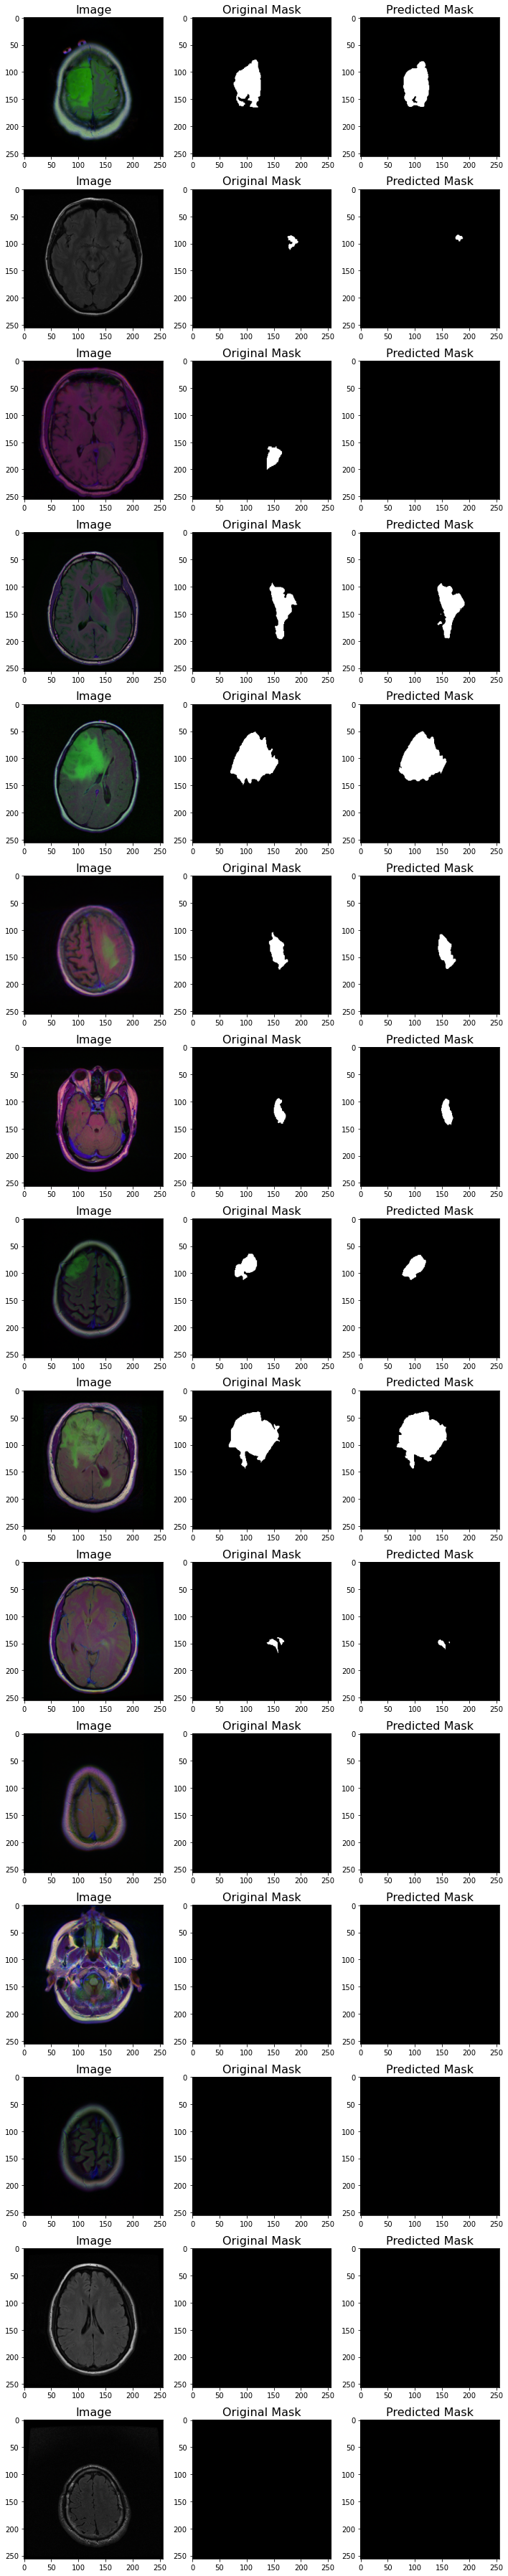

In [51]:
plt.figure(figsize=(10,50))

titles = ["Image", "Original Mask", "Predicted Mask"]

for j in range(15):
    images = [disp_x[j], y[j], preds_t[j]**255]
    for i in range(0, 3):
        ax = plt.subplot(15, 3, (j*3)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')
        
plt.tight_layout()
plt.show()

## 9. Results

* loss = -0.8960
* binary_accuracy: 0.9979
* iou: 0.8134
* dice_coef: 0.8960
* val_loss: -0.8648
* val_binary_accuracy: 0.9976 
* val_iou: 0.7659 
* val_dice_coef: 0.8648


<img src="utils\lossgraph.jpg">

<img src="utils\accuracygraph.jpg">

## 10. Observations

**Loss was not improving after 2nd epoch(it was remaining same)**

* Shuffle data - Done, No improvement
* Add BatchNormalization layer - Done, Significant improvement


**Masks predicted were not accurate. It was covering majority area of image. Seems model is overfit**

* Decrease learning rate - Done(set lr to 1e-3), No improvement
* Decrease no. of filters - Done(Halfed no. of filters at each layers), Some improvement
* Decrease learning rate - Done(set lr to 1e-4), No improvement hence setting back to 1e-3
* Add dropout layers, Updated patience from 3 to 5 - Done, but now model is underfit
* Increase no. of filters - Done
* Load model saved using checkpoint and use it for prediction
* Found that I was not dividing input by 255.